In [ ]:
from __future__ import annotations
import pathlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL

import utils

In [2]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [19]:
recording = "sun11"
vid_path = pathlib.Path("videos") / f"{recording}.mp4"
rec_path = pathlib.Path(f"../data/test-res/466/{recording}") / "reconstructed.mp4"
frames = utils.read_video(vid_path)
rec_frames = utils.read_video(rec_path)
frames.array = utils.crop_vid_to_size(frames.array, 640, 480)

Reading videos\sun11.mp4: 100%|██████████| 1532/1532 [00:05<00:00, 256.86it/s]
Reading ..\data\test-res\466\sun11\reconstructed.mp4: 100%|██████████| 1531/1531 [00:01<00:00, 1439.85it/s]


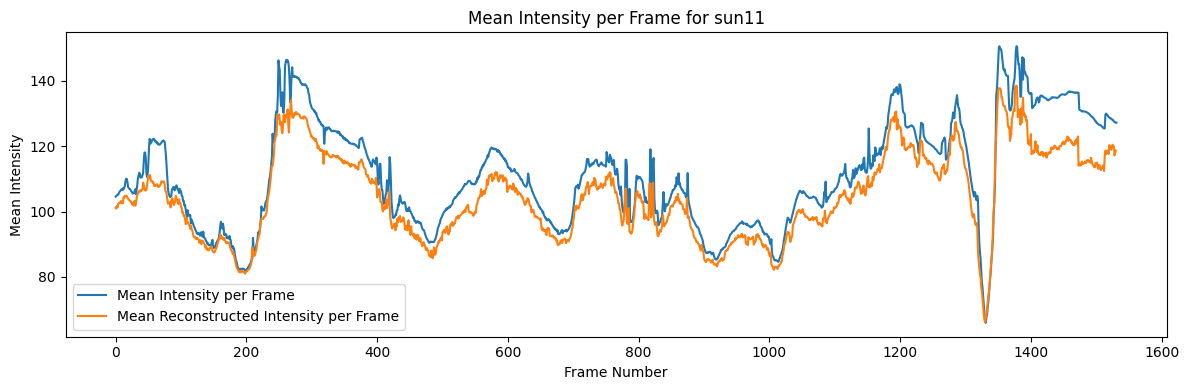

In [20]:
mean_intensity_per_frame = frames.array.mean(axis=(1, 2, 3))
mean_rec_intensity_per_frame = rec_frames.array.mean(axis=(1, 2, 3))

plt.figure(figsize=(12, 4))
plt.plot(mean_intensity_per_frame, label="Mean Intensity per Frame")
plt.plot(mean_rec_intensity_per_frame, label="Mean Reconstructed Intensity per Frame")
plt.xlabel("Frame Number")
plt.ylabel("Mean Intensity")
plt.title(f"Mean Intensity per Frame for {recording}")
plt.legend()
plt.tight_layout()
plt.show()

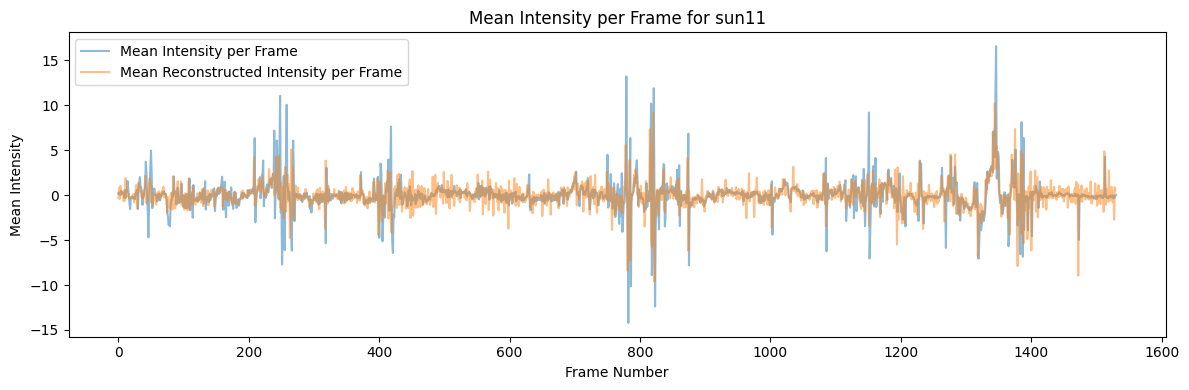

In [ ]:
change_in_mean_intensity = np.diff(mean_intensity_per_frame)
change_in_mean_rec_intensity = np.diff(mean_rec_intensity_per_frame)
plt.figure(figsize=(12, 4))
plt.plot(change_in_mean_intensity, label="Mean Intensity per Frame", alpha=0.5)
plt.plot(
    change_in_mean_rec_intensity,
    label="Mean Reconstructed Intensity per Frame",
    alpha=0.5,
)
plt.xlabel("Frame Number")
plt.ylabel("Mean Intensity")
plt.title(f"Mean Intensity per Frame for {recording}")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
change_in_mean_intensity.max(), change_in_mean_rec_intensity.max()

(16.583830295138895, 10.228681640624998)